<a href="https://colab.research.google.com/github/pitthexai/IEEE_BHI_2023_Tutorial_From_Few_to_None/blob/main/Code/FewShotSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segmentation-models-pytorch --quiet

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import matplotlib.pyplot as plt

from PIL import Image


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils as smp_utils


from zipfile import ZipFile

In [3]:
! wget https://github.com/pitthexai/IEEE_BHI_2023_Tutorial_From_Few_to_None/raw/bcce5fd52b349659fb03fd065f9037e70acc83a9/SampleDataset/BHI_Segmentation.zip
! unzip /content/BHI_Segmentation.zip

--2023-10-15 03:11:15--  https://github.com/pitthexai/IEEE_BHI_2023_Tutorial_From_Few_to_None/raw/bcce5fd52b349659fb03fd065f9037e70acc83a9/SampleDataset/BHI_Segmentation.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pitthexai/IEEE_BHI_2023_Tutorial_From_Few_to_None/bcce5fd52b349659fb03fd065f9037e70acc83a9/SampleDataset/BHI_Segmentation.zip [following]
--2023-10-15 03:11:15--  https://raw.githubusercontent.com/pitthexai/IEEE_BHI_2023_Tutorial_From_Few_to_None/bcce5fd52b349659fb03fd065f9037e70acc83a9/SampleDataset/BHI_Segmentation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12614

In [4]:
DATA_ROOT = "/content/BHI_Segmentation"
SAVE_DIR = "/content/checkpoints/"
SHOT = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RANDOM_STATE = 42

In [5]:
class JointSpaceSegmentationDataset(Dataset):
    def __init__(self, img_root, mask_root, image_files, mask_files, transforms=None, preprocessing=None):
        self.img_root = img_root
        self.mask_root = mask_root
        self.img_files = image_files
        self.mask_files = mask_files
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        image = np.array(Image.open(os.path.join(self.img_root, self.img_files[idx])))
        mask = np.array(Image.open(os.path.join(self.mask_root, self.mask_files[idx])))

        # image = np.stack([image, image, image], axis=0)
        # mask = np.expand_dims(mask, axis=0)
        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        mask = torch.unsqueeze(mask, 0)
        if self.preprocessing is not None:
            transformed = self.preprocessing(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        return image.type(torch.FloatTensor), mask/255.0

In [6]:
from sklearn.model_selection import train_test_split
def generate_datasets(root_dir):
    x_dir = os.path.join(root_dir, "Images")
    y_dir = os.path.join(root_dir, "Annotations")
    records = [[img.split(".")[0][:-1], img, img] for img in os.listdir(x_dir) if img != ".DS_Store"]

    data_records = pd.DataFrame(records, columns=["pid", "images", "masks"])

    train, test = train_test_split(data_records.pid.unique(), test_size=0.5, random_state=RANDOM_STATE)
    valid, test = train_test_split(test, test_size=0.5, random_state=RANDOM_STATE)

    train = data_records[data_records.pid.isin(train)].reset_index(drop=True)
    valid = data_records[data_records.pid.isin(valid)].reset_index(drop=True)
    test = data_records[data_records.pid.isin(test)].reset_index(drop=True)

    return train, valid, test

In [7]:
def get_few_shot_sample(dataset, k=1, random_state=RANDOM_STATE):
    if k > len(dataset):
        return dataset

    return dataset.sample(k, random_state=random_state).reset_index(drop=True)

In [8]:
train, valid, test = generate_datasets(os.path.join(DATA_ROOT))

In [9]:
train_few = get_few_shot_sample(train, k=SHOT)
valid_few = get_few_shot_sample(valid, k=SHOT)

In [10]:
train_few, valid_few

(       pid        images         masks
 0  9981798  9981798R.png  9981798R.png
 1  9977206  9977206R.png  9977206R.png
 2  9980274  9980274R.png  9980274R.png
 3  9986838  9986838L.png  9986838L.png
 4  9985321  9985321L.png  9985321L.png
 5  9981798  9981798L.png  9981798L.png
 6  9980274  9980274L.png  9980274L.png
 7  9986355  9986355R.png  9986355R.png
 8  9988186  9988186L.png  9988186L.png
 9  9980704  9980704R.png  9980704R.png,
        pid        images         masks
 0  9982251  9982251L.png  9982251L.png
 1  9980752  9980752R.png  9980752R.png
 2  9980752  9980752L.png  9980752L.png
 3  9981316  9981316R.png  9981316R.png
 4  9979265  9979265L.png  9979265L.png
 5  9979306  9979306L.png  9979306L.png
 6  9980800  9980800R.png  9980800R.png
 7  9982251  9982251R.png  9982251R.png
 8  9976720  9976720R.png  9976720R.png
 9  9976720  9976720L.png  9976720L.png)

In [11]:
def get_preprocessing_fn(encoder, encoder_weights):
    return smp.encoders.get_preprocessing_fn(encoder, encoder_weights)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        A.Lambda(image=preprocessing_fn),
        ToTensorV2(),
    ]
    return A.Compose(_transform)

In [12]:
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

In [13]:
train_augmentations = A.Compose([A.Resize(256, 256), A.Rotate(15), A.RandomBrightness(0.2),
                                 A.RandomContrast(0.2),  ToTensorV2()])

test_augmentations = A.Compose([A.Resize(256, 256), ToTensorV2()])
train_set = JointSpaceSegmentationDataset(os.path.join(DATA_ROOT, "Images"),
                                          os.path.join(DATA_ROOT, "Annotations"),
                                          train_few.images, train_few.masks,
                                          preprocessing=None,#get_preprocessing(preprocessing_fn),
                                          transforms=train_augmentations)

valid_set = JointSpaceSegmentationDataset(os.path.join(DATA_ROOT, "Images"),
                                          os.path.join(DATA_ROOT, "Annotations"),
                                          valid_few.images, valid_few.masks,
                                          preprocessing=None,#get_preprocessing(preprocessing_fn),
                                          transforms=test_augmentations)

test_set = JointSpaceSegmentationDataset(os.path.join(DATA_ROOT, "Images"),
                                         os.path.join(DATA_ROOT, "Annotations"),
                                         test.images, test.masks,
                                         preprocessing=None,#get_preprocessing(preprocessing_fn),
                                         transforms=test_augmentations)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [14]:
encoder = "resnet18"
encoder_weights = "imagenet"
activation = "sigmoid"
num_classes = 1 # 0=background, 1=joint space

In [15]:
import copy
model = copy.deepcopy(smp.Unet(encoder_name=encoder, encoder_weights=encoder_weights, in_channels=1,
                 classes=num_classes, activation=activation))
model.encoder.requires_grad_ = True
model = model.to(DEVICE)
loss = nn.BCELoss()
loss.__name__="loss"
metrics = [smp_utils.metrics.IoU(threshold=0.5, activation=None), smp_utils.metrics.Fscore(0.5, activation=None)]
optimizer = torch.optim.Adam(model.parameters(), lr=5e-04)

In [16]:
train_loader = DataLoader(train_set, batch_size=2, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=2, shuffle=False, num_workers=2)

In [17]:
# create epoch runners
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [18]:
# train model for 40 epochs

max_score = 0

for i in range(1, 101):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, f'{SAVE_DIR}/best_model_{SHOT}_shot.pth')
        print('Model saved!')



Epoch: 1
valid: 100%|██████████| 5/5 [00:00<00:00, 16.58it/s, loss - 0.531, iou_score - 0.02734, fscore - 0.04036]
Model saved!

Epoch: 2
valid: 100%|██████████| 5/5 [00:00<00:00, 17.46it/s, loss - 0.4471, iou_score - 0.1337, fscore - 0.1971]
Model saved!

Epoch: 3
valid: 100%|██████████| 5/5 [00:00<00:00, 17.14it/s, loss - 0.4396, iou_score - 0.3117, fscore - 0.4131]
Model saved!

Epoch: 4
valid: 100%|██████████| 5/5 [00:00<00:00, 17.14it/s, loss - 0.3244, iou_score - 0.3156, fscore - 0.5428]
Model saved!

Epoch: 5
valid: 100%|██████████| 5/5 [00:00<00:00, 16.85it/s, loss - 0.245, iou_score - 0.5486, fscore - 0.7473]
Model saved!

Epoch: 6
valid: 100%|██████████| 5/5 [00:00<00:00, 16.10it/s, loss - 0.2249, iou_score - 0.5156, fscore - 0.7721]

Epoch: 7
valid: 100%|██████████| 5/5 [00:00<00:00, 15.64it/s, loss - 0.2015, iou_score - 0.5996, fscore - 0.7365]
Model saved!

Epoch: 8
valid: 100%|██████████| 5/5 [00:00<00:00, 17.33it/s, loss - 0.177, iou_score - 0.6258, fscore - 0.8347]
Mod

In [19]:
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=2)
test_img, test_mask  = next(iter(test_loader))

In [20]:
model = torch.load(f'{SAVE_DIR}/best_model_{SHOT}_shot.pth')
model = model.cuda()

avg_iou = 0.0
avg_fscore = 0.0
iou_metric = smp.utils.metrics.IoU(threshold=0.5)
fscore_metric = smp.utils.metrics.Fscore(threshold=0.5)
for img, mask in test_loader:
    out = model(img.to(DEVICE))
    mask = mask.to(DEVICE)
    avg_iou += iou_metric(out, mask).item()
    avg_fscore += fscore_metric(out, mask).item()

print(f"Test IoU: {avg_iou/len(test_loader)}\nTest Dice Score: {avg_fscore/len(test_loader)}")

Test IoU: 0.824797449367387
Test Dice Score: 0.8987680929047721


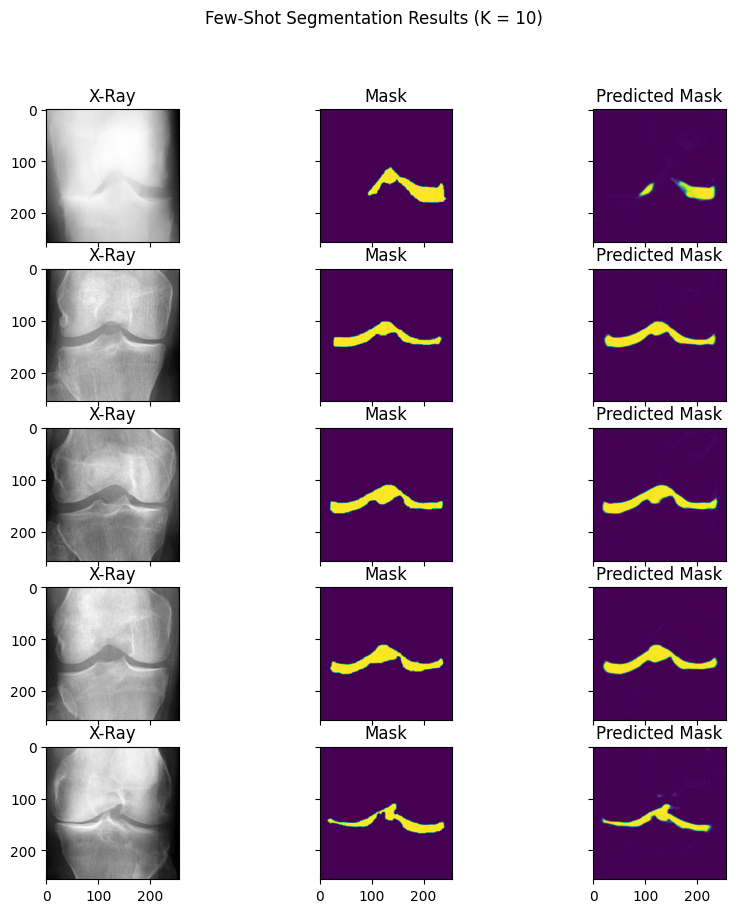

In [21]:
fig, ax = plt.subplots(5, 3, figsize=(10, 10), sharex=True, sharey=True)
fig.suptitle(f"Few-Shot Segmentation Results (K = {SHOT})")
for i, (img, mask) in enumerate(test_loader):
    ax[i, 0].imshow(img[0][0,:,:].squeeze(),cmap="gray")
    ax[i, 0].set_title("X-Ray")
    ax[i, 1].imshow(mask.squeeze())
    ax[i, 1].set_title("Mask")
    ax[i, 2].imshow(torch.sigmoid(model(img.to(DEVICE)).squeeze().detach().cpu()).numpy())
    ax[i, 2].set_title("Predicted Mask")

    if (i + 1) == 5:
        break